# Short Text Language Identification
## Given a string of text, return the language it's written in.
Helpful pre-reads:
* https://www.slideshare.net/shuyo/language-detection-library-for-java
* https://towardsdatascience.com/deep-neural-network-language-identification-ae1c158f6a7d
* https://towardsdatascience.com/animated-rnn-lstm-and-gru-ef124d06cf45

In [1]:
import os
import re
import datetime
from typing import Any

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

### Initial data setup

In [2]:
data = pd.read_csv('sentences.csv',
                    sep='\t', 
                    encoding='utf8', 
                    index_col=0,
                    names=['lang', 'text'])

# filter by text length
len_cond = [True if 20 <= len(s) <= 200 else False for s in data['text']]
data = data[len_cond]

# filter by text language
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
data = data[data['lang'].isin(lang)]

# select 50000 rows for each language
data_trimmed = pd.DataFrame(columns=['lang', 'text'])

for l in lang:
    lang_trim = data[data['lang'] == l].sample(50000, random_state=42)
    data_trimmed = data_trimmed.append(lang_trim)

data_trimmed.shape

(300000, 2)

In [3]:
X = np.array(data_trimmed['text'])
y = np.array(data_trimmed['lang'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

## How do we represent a sentence?

Assumptions: all text is in Unicode.

We will first consider the "bag of words" approach to represent a sentence. The count of each word in a bag of words represents one feature.

No stemming or stop word removal is done as that could lead to information loss regarding the text's language.

In addition, we can use trigrams (3 letter combinations) rather than full words for our approach. This aims to capture the character to character probabilities as opposed to the word to word probabilities.

In [161]:
def get_ngrams(corpus, n_gram, n_feat=200):
    """
    Returns a list of the N most common character ngrams from a list of sentences
    params
    ------------
        corpus: list of strings
        n_gram: number that represents the n in n-gram
        n_feat: integer
    """
    
    # fit the n-gram model
    vectorizer = CountVectorizer(analyzer='char',
                                 ngram_range=(n_gram, n_gram),
                                 max_features=n_feat)
    
    X = vectorizer.fit_transform(corpus)
    
    # get model feature names
    return vectorizer.get_feature_names()

### Generate a vocabulary from all the languages

In order to convert a text to a bag of trigrams, we need to understand what are all possible trigrams for a given language.

Thus we will process all the text for a given language and obtain the top most frequent trigrams from each language. We will combine all of these trigrams into one giant bag, dubbed our vocabulary.

Then when a sentence comes in during training & eval, we will convert it to a count dictionary. Each key in our dictionary is a trigram from our vocabulary. Each key, count pairing represents a feature.

In [5]:
features = {}
features_set = set()
training_corpus = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
training_corpus.columns = ['text', 'lang']

for l in lang:
    # get corpus filtered by language
    corpus = training_corpus[training_corpus['lang']==l]['text']
    
    # get 200 most frequent trigrams
    trigrams = get_ngrams(corpus, 3)
    
    # add to dict and set
    features[l] = trigrams 
    features_set.update(trigrams)

    
# create vocabulary list using feature set
vocab = dict()
for i, f in enumerate(features_set):
    vocab[f] = i

In [6]:
# train count vectoriser using vocabulary
vectorizer = CountVectorizer(analyzer='char',
                             ngram_range=(3, 3),
                             vocabulary=vocab)

# create feature matrix from training set  
X_train_feat_vec = vectorizer.fit_transform(X_train)
feature_names = vectorizer.get_feature_names()
print(X_train_feat_vec.shape)
print(len(feature_names))

train_feat = pd.DataFrame(data=X_train_feat_vec.toarray(), columns=feature_names)
train_feat.max()

(240000, 666)
666


abe    5
ene    3
 pi    5
ary    2
was    6
      ..
el     7
uir    2
ith    6
n t    5
 mo    5
Length: 666, dtype: int64

Each sentence will have 666 features. We will have 240,000 training instances and 60,000 test cases.

In [7]:
X_test_feat_vec = vectorizer.fit_transform(X_test)
feature_names = vectorizer.get_feature_names()
print(X_test_feat_vec.shape)

test_feat = pd.DataFrame(data=X_test_feat_vec.toarray(), columns=feature_names)

(60000, 666)


### Logistic Regression Baseline

In [8]:
log_clf = LogisticRegression(random_state=42,
                             multi_class='multinomial',
                             solver='newton-cg').fit(train_feat, y_train)
score = model_selection.cross_val_score(log_clf, train_feat, y_train, cv=3)
score.mean()

0.985325

In [9]:
log_clf.score(test_feat, y_test)

0.9867833333333333

### Deep Learning Alternative

Our features stay the same; we are still using the bag of words approach. We will be feeding 666 features per training instance into the first layer of our neural network.

We will need to encode the output though so we will use the `LabelEncoder` class from `sklearn`.

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# fit encoder
encoder = LabelEncoder()
encoder.fit(lang)

def encode(y):
    """
    Returns a list of one hot encodings
    Params
    ---------
        y: list of language labels
    """
    
    y_encoded = encoder.transform(y)
    y_dummy = to_categorical(y_encoded)
    
    return y_dummy

In [11]:
%load_ext tensorboard

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GlobalMaxPooling1D, Bidirectional, GRU, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers

# get training data
x = train_feat
y = encode(y_train)

# define model
model = Sequential()
model.add(Dense(500, input_dim=len(vocab), activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

mc = ModelCheckpoint('best_model.h5', monitor='acc', mode='max', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 500)               333500    
_________________________________________________________________
dense_45 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_46 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_47 (Dense)             (None, 6)                 1506      
Total params: 710,756
Trainable params: 710,756
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model
model.fit(x, y, epochs=4, batch_size=100, callbacks=[mc, es, tensorboard_callback])

In [13]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

# evaluation
_, val_acc = model.evaluate(test_feat, encode(y_test), batch_size=100)
val_acc

600/600 [==============================] - 1s 2ms/step - loss: 0.0372 - acc: 0.9892A: 0s - loss: 0.0


0.9891999959945679

Our deep neural network approach works slightly better than our baseline, but that is fine because we are already at 98% accuracy.

0.9892


Text(61.5, 0.5, 'Actual')

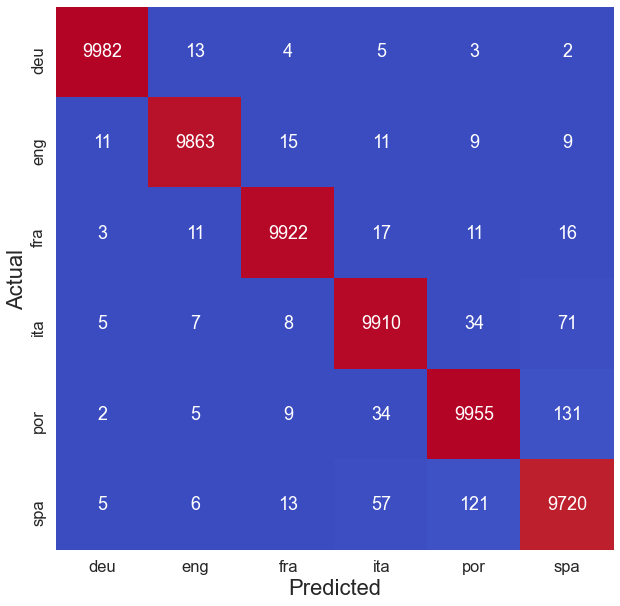

In [14]:
# get predictions on test set
# labels = model.predict_classes(test_feat) # deprecated
labels = np.argmax(model.predict(test_feat), axis=-1)
predictions = encoder.inverse_transform(labels)

# accuracy on test set
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

# create confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=lang, index=lang)

# plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df, cmap='coolwarm', annot=True, fmt='.5g', cbar=False)
plt.xlabel('Predicted', fontsize=22)
plt.ylabel('Actual', fontsize=22)

Looks about right, Portuguese is probably most similar to Spanish so our model got confused.

## Deep learning alternative - LSTMs (experimental)
This time we will focus on capturing the sequential nature of a sentence. We will be using the `LSTM` layer in addition to the traditional `Dense` layer. The LSTM layer is built from LSTM nodes in a neural network. Each LSTM node represents a recurrent neural network node. The general gist is that we can capture sequential information by plugging the output of an LSTM node back into itself. The input to the node is each trigram, in sequence.

#### First we need to reconsider how we selected our data

In [186]:
data = pd.read_csv('sentences.csv',
                    sep='\t', 
                    encoding='utf8', 
                    index_col=0,
                    names=['lang', 'text'])

max_length = 180

# filter by text length
len_cond = [True if 50 <= len(s) <= max_length else False for s in data['text']]
data = data[len_cond]

# filter by text language
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
data = data[data['lang'].isin(lang)]

# select 50000 rows for each language
data_trimmed = pd.DataFrame(columns=['lang', 'text'])

print(data.groupby(['lang']).count())

for l in lang:
    lang_trim = data[data['lang'] == l].sample(50000, random_state=42)
    data_trimmed = data_trimmed.append(lang_trim)

data_trimmed.shape

        text
lang        
deu   165708
eng   249115
fra    99712
ita    77609
por    61910
spa    64407


(300000, 2)

In [187]:
X = np.array(data_trimmed['text'])
y = np.array(data_trimmed['lang'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [188]:
X_train[0]

'Eran las tantas de la madrugada y todavía no habían terminado la tarea.'

In [189]:
get_ngrams(['hello my name is michael'], 3)

[' is',
 ' mi',
 ' my',
 ' na',
 'ael',
 'ame',
 'cha',
 'e i',
 'ell',
 'hae',
 'hel',
 'ich',
 'is ',
 'llo',
 'lo ',
 'me ',
 'mic',
 'my ',
 'nam',
 'o m',
 's m',
 'y n']

In [190]:
features = {}
features_set = set()
training_corpus = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
training_corpus.columns = ['text', 'lang']

for l in lang:
    # get corpus filtered by language
    corpus = training_corpus[training_corpus['lang']==l]['text']
    
    # get 300 most frequent trigrams
    chars = get_ngrams(corpus, 1, 300)
    
    # add to dict and set
    features[l] = chars 
    features_set.update(chars)

    
# create vocabulary list using feature set
chars_vocab = dict()
for i, f in enumerate(features_set):
    chars_vocab[f] = i

In [191]:
text = 'my name is michael'
[text[i: i + 3] for i in range(0, len(text), 3)]

['my ', 'nam', 'e i', 's m', 'ich', 'ael']

In [192]:
chars_vocab

{'h': 0,
 '~': 1,
 '□': 2,
 'o': 3,
 'の': 4,
 'p': 5,
 'a': 6,
 'ô': 7,
 '℃': 8,
 'ż': 9,
 'и': 10,
 '𝑚': 11,
 '$': 12,
 'д': 13,
 'ė': 14,
 '0': 15,
 'b': 16,
 '⁴': 17,
 'ê': 18,
 '⁰': 19,
 '\t': 20,
 'ă': 21,
 'ŝ': 22,
 '/': 23,
 'ō': 24,
 '𝑒': 25,
 'у': 26,
 ']': 27,
 'v': 28,
 'z': 29,
 'u': 30,
 '–': 31,
 'ª': 32,
 '*': 33,
 'n': 34,
 '𝑏': 35,
 'â': 36,
 'r': 37,
 'ú': 38,
 'ǎ': 39,
 'ù': 40,
 'ь': 41,
 'i': 42,
 '？': 43,
 '½': 44,
 '̉': 45,
 '言': 46,
 'ä': 47,
 'ğ': 48,
 '_': 49,
 'ò': 50,
 ' ': 51,
 'ü': 52,
 'τ': 53,
 '“': 54,
 '、': 55,
 '#': 56,
 'о': 57,
 'ā': 58,
 'て': 59,
 '⁷': 60,
 '么': 61,
 'í': 62,
 'ĝ': 63,
 'あ': 64,
 'õ': 65,
 'υ': 66,
 'в': 67,
 'c': 68,
 '”': 69,
 'k': 70,
 'ø': 71,
 'ņ': 72,
 ':': 73,
 'ḥ': 74,
 'р': 75,
 '─': 76,
 'ö': 77,
 'ć': 78,
 '什': 79,
 '₪': 80,
 '&': 81,
 'ồ': 82,
 '🌡': 83,
 '2': 84,
 '5': 85,
 'ł': 86,
 'º': 87,
 'λ': 88,
 'θ': 89,
 'γ': 90,
 'ʻ': 91,
 '甚': 92,
 '\xa0': 93,
 'f': 94,
 '\u200e': 95,
 'а': 96,
 'α': 97,
 '4': 98,
 'ñ': 99,
 

In [193]:
def text_to_sequences_of_ngrams(text: str, vocab: dict, n_gram_length: int = 3):
    """
    Returns a list of numbers that represent the indice of the word in our vectorizer
    Represents the a sequence of n-grams
    ---------
    Params
    ---------
        text: sentence to be converted
        n_gram_length: size of n-gram to use
        vectorizer: a CountVectorizer fit on the vocabulary of the corpus
            (vocab assembled from top trigrams of each language)
    """
    n_gram_sequence = [text[i: i + n_gram_length] for i in range(0, len(text), n_gram_length)]
    encoded_output = []
    for n_gram in n_gram_sequence:
        if n_gram in vocab:
            encoded_output.append(vocab[n_gram])
        else:
            encoded_output.append(-1)
            
    return encoded_output

In [194]:
# this approach is ok but we want to use n-grams instead to handle short text classification
# see: https://stackoverflow.com/questions/46173502/using-keras-tokenizer-to-generate-n-grams
'''
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenize the sentences
tokenizer = Tokenizer()

# preparing vocabulary
tokenizer.fit_on_texts(list(X_train))

# converting text into integer sequences
x_train_seq  = tokenizer.texts_to_sequences(X_train)
x_test_seq = tokenizer.texts_to_sequences(X_test)

# padding to prepare sequences of same length
x_train_seq  = pad_sequences(x_train_seq, maxlen=200, padding='post')
print(x_train_seq.shape)
x_test_seq = pad_sequences(x_test_seq, maxlen=200, padding='post')
print(x_test_seq.shape)

x_train_seq[0]
'''
from tensorflow.keras.preprocessing.sequence import pad_sequences

n_gram = 1
maxlen = max_length // n_gram

x_train_seq = []
for sentence in X_train:
    x_train_seq.append(text_to_sequences_of_ngrams(sentence, chars_vocab, n_gram))
x_train_seq = pad_sequences(x_train_seq, maxlen=maxlen)
    
x_test_seq = []
for sentence in X_test:
    x_test_seq.append(text_to_sequences_of_ngrams(sentence, chars_vocab, n_gram))
x_test_seq = pad_sequences(x_test_seq, maxlen=maxlen)

x_train_seq[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  -1,  37,   6,  34,  51, 133,   6, 150,
        51, 140,   6,  34, 140,   6, 150,  51, 224, 252,  51, 133,   6,
        51, 229,   6, 224,  37,  30, 214,   6, 224,   6,  51, 115,  51,
       140,   3, 224,   6,  28,  62,   6,  51,  34,   3,  51,   0,   6,
        16,  62,   6,  34,  51, 140, 252,  37, 229,  42,  34,   6, 224,
         3,  51, 133,   6,  51, 140,   6,  37, 252,   6, 102], d

### Update on input shape
Rather than our original `(240000, 666)` shape, we now have `(240000, maxlen)` shape. This is because we now have `maxlen` features to represent a sentence, where each feature is what trigram/bigram/char was used. We will be feeding each of these features in sequence to our LSTM layer. 

In [195]:
data = [[11, 22],
    [33, 44],
    [55, 66]]
data = np.array(data)
print(data.shape)
data = data.reshape((data.shape[0], data.shape[1], 1))
print(data.shape)
data

(3, 2)
(3, 2, 1)


array([[[11],
        [22]],

       [[33],
        [44]],

       [[55],
        [66]]])

In [196]:
x_train_seq = x_train_seq.reshape((x_train_seq.shape[0], x_train_seq.shape[1], 1)).astype(float)
x_train_seq.shape

(240000, 180, 1)

In [197]:
x_test_seq = x_test_seq.reshape((x_test_seq.shape[0], x_test_seq.shape[1], 1)).astype(float)
x_test_seq.shape

(60000, 180, 1)

In [198]:
# not taking this approach
# print(tokenizer.word_index)
# size_of_vocabulary = len(tokenizer.word_index)
# size_of_vocabulary

# instead
size_of_vocab = len(chars_vocab)
size_of_vocab

257

In [199]:
# this is 2D which won't work
# we need 3D tensor fed into an LSTM
# (num samples x num timesteps x representation of trigram/word)
x.shape

(240000, 666)

In [200]:
x_train_seq.shape[1], x_train_seq.shape[2]

(180, 1)

### Our LSTM model

In [201]:
lstm_model = Sequential()

# lstm layer - https://keras.io/api/layers/recurrent_layers/lstm/
lstm_model.add(
    Bidirectional(
        LSTM(256, return_sequences=True, dropout=0.3),
        input_shape=(x_train_seq.shape[1], x_train_seq.shape[2])
    )
)

lstm_model.add(GlobalMaxPooling1D())

lstm_model.add(
    Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    )
)
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(6, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

mc = ModelCheckpoint('best_lstm_model.h5', monitor='acc', mode='max', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

lstm_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 180, 512)          528384    
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 512)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_66 (Dense)             (None, 6)                 102       
Total params: 596,214
Trainable params: 596,214
Non-trainable params: 0
_______________________________________________

In [202]:
# Train model
lstm_model.fit(x_train_seq, encode(y_train), epochs=12, validation_split=0.25, batch_size=100, callbacks=[mc, es, tensorboard_callback])

Epoch 1/12
2400/2400 [==============================] - ETA: 0s - loss: 0.8113 - acc: 0.6671
Epoch 00001: acc improved from -inf to 0.66705, saving model to best_lstm_model.h5
2400/2400 [==============================] - 1577s 657ms/step - loss: 0.8113 - acc: 0.6671
Epoch 2/12
2400/2400 [==============================] - ETA: 0s - loss: 0.2832 - acc: 0.8973
Epoch 00002: acc improved from 0.66705 to 0.89735, saving model to best_lstm_model.h5
2400/2400 [==============================] - 1578s 657ms/step - loss: 0.2832 - acc: 0.8973
Epoch 3/12
2400/2400 [==============================] - ETA: 0s - loss: 0.1759 - acc: 0.9388
Epoch 00003: acc improved from 0.89735 to 0.93883, saving model to best_lstm_model.h5
2400/2400 [==============================] - 1656s 690ms/step - loss: 0.1759 - acc: 0.9388
Epoch 4/12
2400/2400 [==============================] - ETA: 0s - loss: 0.1323 - acc: 0.9547
Epoch 00004: acc improved from 0.93883 to 0.95467, saving model to best_lstm_model.h5
2400/2400 [===

In [203]:
lstm_model = load_model('best_lstm_model.h5')

# evaluation
loss, val_acc = lstm_model.evaluate(x_test_seq, encode(y_test), batch_size=100, verbose=2)
val_acc

600/600 [==============================] - 137s 228ms/step - loss: 1.9123 - acc: 0.5071


0.5070833563804626

It seems like our LSTM model was overfit and still full of bias.

0.5070833333333333


Text(61.5, 0.5, 'Actual')

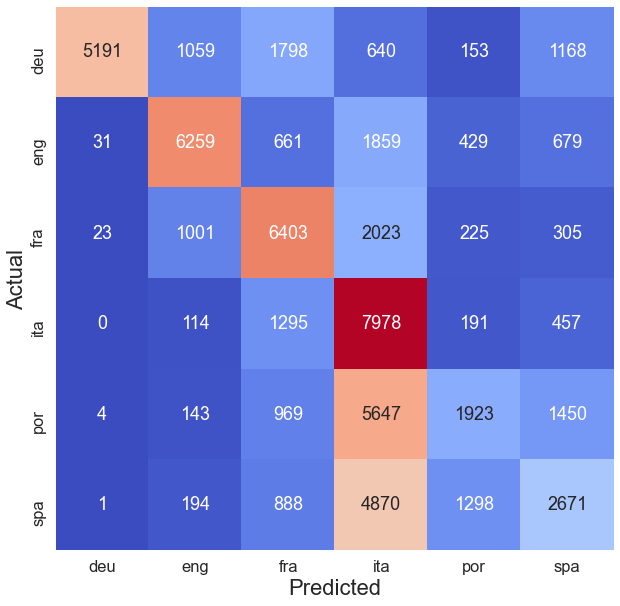

In [204]:
# Get predictions on test set
labels = np.argmax(lstm_model.predict(x_test_seq), axis=-1)
predictions = encoder.inverse_transform(labels)

accuracy = accuracy_score(y_test, predictions)
print(accuracy)

conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=lang, index=lang)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df, cmap='coolwarm', annot=True, fmt='.5g', cbar=False)
plt.xlabel('Predicted', fontsize=22)
plt.ylabel('Actual', fontsize=22)

In [205]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 5609), started 2 days, 18:50:55 ago. (Use '!kill 5609' to kill it.)